<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Get-bands-3,-4--(green,-red)" data-toc-modified-id="Get-bands-3,-4--(green,-red)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Get bands 3, 4  (green, red)</a></span></li><li><span><a href="#Rename-the-band-5-tiff-file-created-by-the-image_zoom-notebook" data-toc-modified-id="Rename-the-band-5-tiff-file-created-by-the-image_zoom-notebook-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Rename the band 5 tiff file created by the image_zoom notebook</a></span></li><li><span><a href="#Open-the-small-file-and-get-the-transform" data-toc-modified-id="Open-the-small-file-and-get-the-transform-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Open the small file and get the transform</a></span></li><li><span><a href="#Use-the-transform-to-make-a-Window-with-the-correct-ul-corner" data-toc-modified-id="Use-the-transform-to-make-a-Window-with-the-correct-ul-corner-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Use the transform to make a Window with the correct ul corner</a></span></li><li><span><a href="#Read-only-the-window-pixels-from-the-band-3,-4-files" data-toc-modified-id="Read-only-the-window-pixels-from-the-band-3,-4-files-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Read only the window pixels from the band 3, 4 files</a></span></li><li><span><a href="#check-to-make-sure-the-read-worked" data-toc-modified-id="check-to-make-sure-the-read-worked-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>check to make sure the read worked</a></span></li><li><span><a href="#Compare-the-green-and-red-bands" data-toc-modified-id="Compare-the-green-and-red-bands-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Compare the green and red bands</a></span></li><li><span><a href="#Write-out-a-new-composite" data-toc-modified-id="Write-out-a-new-composite-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Write out a new composite</a></span></li></ul></div>

# Introduction

We've got a new tiff file for band 5 called small_file.tiff that was written out by the image_zoom notebook.  We can use the corners of that image to clip other bands and save
us the trouble of working with the large original files.

Below I use the [rasterio windows module](https://rasterio.readthedocs.io/en/latest/topics/windowed-rw.html) to read in only the part of the image that matches small_file.tiff

In [1]:
import rasterio
import a301
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
from a301.landsat.landsat_metadata import landsat_metadata
import cartopy
from rasterio.windows import Window
from pyproj import transform as proj_transform
from pyproj import Proj
from a301.landsat.toa_reflectance import calc_reflc_8
import pprint
from a301.utils.data_read import download
from pathlib import Path
from affine import Affine
from IPython.display import Image


# Get bands 3, 4  (green, red)

In [2]:
filenames=["LC08_L1TP_047026_20150614_20180131_01_T1_B4.TIF",
    "LC08_L1TP_047026_20150614_20180131_01_T1_B3.TIF",
    "LC08_L1TP_047026_20150614_20180131_01_T1_MTL.txt"]
dest_folder=a301.data_dir / Path("landsat8/vancouver")
dest_folder.mkdir(parents=True, exist_ok=True)
for the_file in filenames:
    landsat_tif = Path('landsat_scenes/l8_vancouver') / Path(the_file)
    download(str(landsat_tif),dest_folder=dest_folder)
    
band4_bigfile=list(dest_folder.glob("*20180131*B4.TIF"))[0]
band3_bigfile=list(dest_folder.glob("*20180131*B3.TIF"))[0]
meta_bigfile=list(dest_folder.glob("*20180131*MTL.txt"))[0]
with rasterio.open(band4_bigfile) as raster:
    big_transform=raster.transform
    big_profile=raster.profile

trying https://clouds.eos.ubc.ca/~phil/courses/atsc301/downloads/landsat_scenes/l8_vancouver/LC08_L1TP_047026_20150614_20180131_01_T1_B4.TIF
writing to: /Users/phil/repos/a301_code/data/landsat8/vancouver/LC08_L1TP_047026_20150614_20180131_01_T1_B4.TIF

LC08_L1TP_047026_20150614_20180131_01_T1_B4.TIF already exists
and is 75252265 bytes
will not overwrite

trying https://clouds.eos.ubc.ca/~phil/courses/atsc301/downloads/landsat_scenes/l8_vancouver/LC08_L1TP_047026_20150614_20180131_01_T1_B3.TIF
writing to: /Users/phil/repos/a301_code/data/landsat8/vancouver/LC08_L1TP_047026_20150614_20180131_01_T1_B3.TIF

LC08_L1TP_047026_20150614_20180131_01_T1_B3.TIF already exists
and is 74130783 bytes
will not overwrite

trying https://clouds.eos.ubc.ca/~phil/courses/atsc301/downloads/landsat_scenes/l8_vancouver/LC08_L1TP_047026_20150614_20180131_01_T1_MTL.txt
writing to: /Users/phil/repos/a301_code/data/landsat8/vancouver/LC08_L1TP_047026_20150614_20180131_01_T1_MTL.txt

LC08_L1TP_047026_20150614_

# Rename the band 5 tiff file created by the image_zoom notebook

Change it from small_file.tiff to the more descriptive band5_reflect.tiff
Note that this will fail the second time this cell is executed, so ignore that error

In [3]:
try:
    tiff_filename=a301.data_dir / Path('small_file.tiff')   
    band5_smallfile=a301.data_dir / Path('band5_reflect.tiff') 
    os.rename(tiff_filename,band5_smallfile)
except FileNotFoundError:
    pass

# Open the small file and get the transform

In [4]:
with rasterio.open(band5_smallfile) as raster:
    small_transform=raster.transform
    crs=raster.crs
    small_profile=raster.profile
    b5_refl=raster.read(1)
    

# Use the transform to make a Window with the correct ul corner

In [5]:
metadata=landsat_metadata(meta_bigfile)    
small_ul_xy = small_transform*(0,0)
big_ul_col_row = ~big_transform*(small_ul_xy[:])
big_col, big_row = int(big_ul_col_row[0]),int(big_ul_col_row[1])
small_height,small_width = b5_refl.shape
small_window=Window(big_col, big_row, small_width, small_height)

Scene LC80470262015165LGN02 center time is 2015-06-14 19:00:43


# Read only the window pixels from the band 3, 4 files

In [6]:
refl_dict=dict()
refl_dict[5]=b5_refl
for bandnum,filepath in zip([3,4],[band3_bigfile,band4_bigfile]):
    with rasterio.open(filepath) as src:
        counts = src.read(1, window=small_window)
        refl = calc_reflc_8(counts,bandnum,metadata)
        refl_dict[bandnum]=refl

# check to make sure the read worked

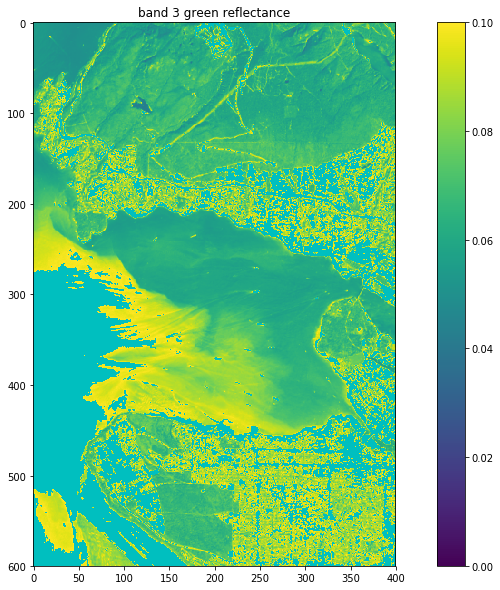

In [7]:
vmin=0.
vmax=0.1
cmap_ref=plt.get_cmap('viridis')
cmap_ref.set_over('c')
cmap_ref.set_under('b',alpha=0.2)
cmap_ref.set_bad('0.75') #75% grey
the_norm=Normalize(vmin=vmin,vmax=vmax,clip=False)
fig, ax1 = plt.subplots(1,1,figsize=(15,10))
cax=ax1.imshow(refl_dict[3],norm=the_norm,cmap=cmap_ref)
fig.colorbar(cax,ax=ax1)
ax1.set_title('band 3 green reflectance');

# Compare the green and red bands

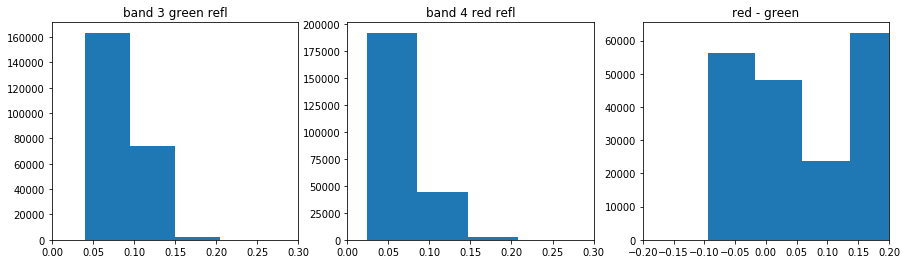

In [11]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,4))
diff = refl_dict[5] - refl_dict[4]
ax1.hist(refl_dict[3][~np.isnan(refl_dict[3])].flat)
ax2.hist(refl_dict[4][~np.isnan(refl_dict[4])].flat)
ax3.hist(diff[~np.isnan(diff)].flat)
ax1.set(title='band 3 green refl',xlim=[0,0.3])
ax2.set(title='band 4 red refl',xlim=[0,0.3])
ax3.set(title='red - green',xlim=[-0.2,0.2]);

# Write out a new composite

ESRI suggests that vegetation looks good if RGB is mapped to [bands 5,4,3](https://www.esri.com/arcgis-blog/products/product/imagery/band-combinations-for-landsat-8).  Reuse the code from the rasterio_demo notebook

In [9]:
from skimage import  img_as_ubyte
from skimage import exposure

height,width = refl_dict[5].shape
num_chans=3
channels=np.empty([num_chans,height,width],dtype=refl_dict[5].dtype)
for index,the_chan in enumerate([5,4,3]):
    channels[index,:,:] = refl_dict[the_chan]

tif_filename= a301.data_dir / Path('vancouver_543.tiff')
with rasterio.open(tif_filename,'w',driver='GTiff',
                   height=height,width=width,
                   count=num_chans,dtype=channels.dtype,
                   crs=crs,transform=small_transform, nodata=0.0) as dst:
    dst.write(channels)
    keys=['5','4','3']
    for index,chan_name in enumerate(keys):
        dst.update_tags(index+1,name=chan_name)

        
with rasterio.open(tif_filename) as infile:
    print(f"\nnew profile: {pprint.pformat(infile.profile)}\n")
    profile=infile.profile

int_channels=np.empty([num_chans,height,width],dtype=np.uint8)    
profile['driver']='PNG'  
profile['dtype'] = 'uint8'
png_filename=tif_filename.with_suffix('.png')
with rasterio.open(png_filename, 'w', **profile) as dst:
    for index,chan in enumerate([5,4,3]):
        image = refl_dict[chan]
        stretched=exposure.equalize_hist(image)   
        int_channels[index,:,:]=img_as_ubyte(stretched)[:,:]
    dst.write(int_channels)


new profile: {'count': 3,
 'crs': CRS({'init': 'epsg:32610'}),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 600,
 'interleave': 'pixel',
 'nodata': 0.0,
 'tiled': False,
 'transform': Affine(30.0, 0.0, 479085.0,
       0.0, -30.0, 5471475.0),
 'width': 400}



/Users/phil/mini37/envs/fiona/lib/python3.7/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


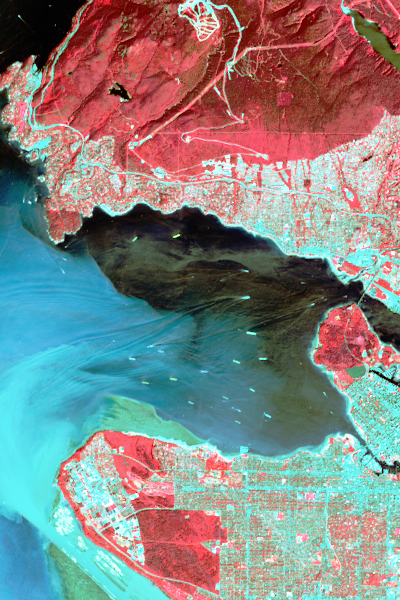

In [10]:
Image(str(png_filename))